In [1]:
!pip install -q -U keras-tuner

In [2]:
import keras_tuner as kt

In [3]:
from tensorflow.keras.datasets import cifar100

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow import keras

In [6]:
(X_nontest, y_nontest), (X_test, y_test) = cifar100.load_data()

# Parse numbers as floats
X_nontest = X_nontest.astype('float32')
X_test = X_test.astype('float32')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
indices = np.random.permutation(X_nontest.shape[0])
training_idx, val_idx = indices[:40000], indices[40000:]
X_train, y_train = X_nontest[training_idx,:], y_nontest[training_idx]
X_val, y_val = X_nontest[val_idx,:], y_nontest[val_idx]

In [8]:
print(f'Training set size: {X_train.shape}')
print(f'Training label size: {y_train.shape}')
print(f'Validation set size: {X_val.shape}')
print(f'Validation label size: {y_val.shape}')
print(f'Test set size: {X_test.shape}')
print(f'Test label size: {y_test.shape}')

Training set size: (40000, 32, 32, 3)
Training label size: (40000, 1)
Validation set size: (10000, 32, 32, 3)
Validation label size: (10000, 1)
Test set size: (10000, 32, 32, 3)
Test label size: (10000, 1)


In [9]:
X_train = (X_train)/255
X_val = (X_val)/255
X_test = (X_test)/255

nb_classes = len(np.unique(y_nontest))
print(nb_classes)
img_width, img_height, img_num_channels = 32, 32, 3
input_shape = (img_width, img_height, img_num_channels)

y_train = to_categorical(y_train, nb_classes)
y_val = to_categorical(y_val, nb_classes)
y_test = to_categorical(y_test, len(np.unique(y_test)))

100


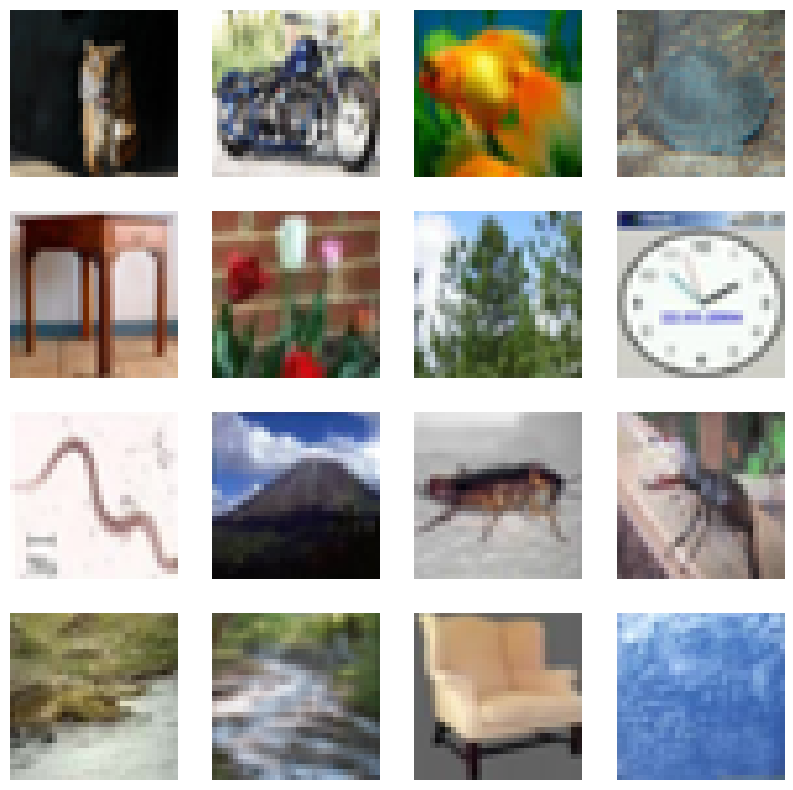

In [10]:
plt.figure(figsize=(10, 10))

for i in range (4*4):
  plt.subplot(4, 4, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')

plt.show()

# Hyperparameter Determination

In [25]:
# Add code for Hyperband builder, tuner and search. Make the dropouts, learning rates non-discrete.

def build_model(hp, nb_classes = 100):
    model = Sequential()
    activation = 'elu'
    dropout_rate = hp.Choice('dropout', values=[0.25, 0.3, 0.5])
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
    num_conv_blocks = hp.Int('num_conv_blocks', min_value=1, max_value=3)
    optimizer_choice = tf.keras.optimizers.Adam(learning_rate=learning_rate)



    # First Conv Block (Fixed)
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation(activation))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Variable blocks
    for i in range(1, num_conv_blocks+1):
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation(activation))

        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))


    # Dense Block (Fixed)
    model.add(Flatten())
    model.add(Dense(32 * (2 ** (i+1))))
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(nb_classes, activation='softmax'))

    model.compile(optimizer=optimizer_choice,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [24]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cifar100_tuning',
    overwrite=True
)

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, 
             epochs=20, 
             # validation_split=0.1, 
             validation_data=(X_val, y_val),
             callbacks=[stop_early])
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters found:")
for hp_name, hp_value in best_trial.hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Trial 30 Complete [00h 02m 32s]
val_loss: 3.0689632892608643

Best val_loss So Far: 1.9525219202041626
Total elapsed time: 00h 25m 44s
Best hyperparameters found:
dropout: 0.3
learning_rate: 0.0001
num_conv_blocks: 3
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020


# Simulation Plots

In [12]:
from tensorflow.keras import optimizers, models, layers

In [12]:
def create_cnn(dropout_rate=0.25, num_layers=2):
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Variable blocks
    for i in range(1, num_layers + 1):
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))

    # Dense Block (Fixed)
    model.add(Flatten())
    model.add(Dense(32 * (2 ** (i + 1))))
    model.add(Activation('elu'))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(nb_classes, activation='softmax'))
    return model

def run_experiment(param_name, param_values, runs_per_param=3):
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)

    histories = []
    for val in param_values:
        print(f"Running {param_name}: {val}")
        run_histories = []
        test_accuracies = []
        for run in range(runs_per_param):
            print(f"  Run {run + 1}/{runs_per_param}")
            # Create new model each time
            if param_name == 'learning_rate':
                model = create_cnn()
                optimizer = optimizers.Adam(learning_rate=val, decay=1e-6)
            elif param_name == 'dropout_rate':
                model = create_cnn(dropout_rate=val)
                optimizer = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
            elif param_name == 'num_CNN_blocks':
                model = create_cnn(num_layers=val)
                optimizer = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
            else:
                raise ValueError("Unknown parameter!")

            model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8, restore_best_weights=True)

            history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                                validation_data=(X_val, y_val),
                                epochs=30,
                                verbose=1,
                                callbacks=[early_stop])
            run_histories.append(history)
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
            test_accuracies.append(test_accuracy)
            print(f"    Test Accuracy Run {run + 1}: {test_accuracy:.4f}")
        avg_test_accuracy = np.mean(test_accuracies)
        print(f"Average Test Accuracy for {param_name}={val}: {avg_test_accuracy:.4f}\n")
        histories.append((val, run_histories))
    return histories

In [13]:
def plot_histories_with_std(histories, param_name):
    def extract_metric(run_histories, metric):
        return [np.interp(np.arange(max_len), np.arange(len(h.history[metric])), h.history[metric]) for h in run_histories]

    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    for val, run_histories in histories:
        print(histories)
        # Ensure all histories are aligned (pad shorter runs)
        max_len = max(len(h.history['loss']) for h in run_histories)
        losses = np.array(extract_metric(run_histories, 'loss'))
        val_losses = np.array(extract_metric(run_histories, 'val_loss'))

        mean_loss = np.mean(losses, axis=0)
        std_loss = np.std(losses, axis=0)
        mean_val_loss = np.mean(val_losses, axis=0)
        std_val_loss = np.std(val_losses, axis=0)

        epochs = np.arange(max_len)
        plt.plot(epochs, mean_loss, label=f"Train Loss - {param_name}: {val}")
        plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

        plt.plot(epochs, mean_val_loss, '--', label=f"Val Loss - {param_name}: {val}")
        plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss vs Epoch ({param_name})")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for val, run_histories in histories:
        max_len = max(len(h.history['accuracy']) for h in run_histories)
        accs = np.array(extract_metric(run_histories, 'accuracy'))
        val_accs = np.array(extract_metric(run_histories, 'val_accuracy'))

        mean_acc = np.mean(accs, axis=0)
        std_acc = np.std(accs, axis=0)
        mean_val_acc = np.mean(val_accs, axis=0)
        std_val_acc = np.std(val_accs, axis=0)

        epochs = np.arange(max_len)
        plt.plot(epochs, mean_acc, label=f"Train Acc - {param_name}: {val}")
        plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)

        plt.plot(epochs, mean_val_acc, '--', label=f"Val Acc - {param_name}: {val}")
        plt.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy vs Epoch ({param_name})")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
if __name__ == "__main__":
    # Experiment 1: Learning Rate
    learning_rates = [1e-3, 1e-4, 1e-5]
    lr_histories = run_experiment('learning_rate', learning_rates)
    plot_histories_with_std(lr_histories, 'Learning Rate')

    # Experiment 2: Dropout Rate
    dropout_rates = [0.25, 0.3, 0.5]
    dropout_histories = run_experiment('dropout_rate', dropout_rates)
    plot_histories_with_std(dropout_histories, 'Dropout Rate')

    # Experiment 3: Number of CNN Layers
    num_layers_list =  [1, 2, 3]
    layers_histories = run_experiment('num_CNN_blocks', num_layers_list)
    plot_histories_with_std(layers_histories, 'Number of CNN Blocks')

Running learning_rate: 0.001
  Run 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.0876 - loss: 4.0752 - val_accuracy: 0.2591 - val_loss: 3.0693
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2323 - loss: 3.1647 - val_accuracy: 0.3336 - val_loss: 2.6780
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2902 - loss: 2.8656 - val_accuracy: 0.3231 - val_loss: 2.7377
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.3169 - loss: 2.7161 - val_accuracy: 0.3890 - val_loss: 2.4061
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.3369 - loss: 2.6179 - val_accuracy: 0.3850 - val_loss: 2.4292
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.3576 - loss: 2.5138 - val_accuracy: 0.4257 - val_loss: 2.2389
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.3692 - loss: 2.4446 - val_accuracy: 0.4189 - val_loss: 2.2564
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.3843 - loss: 2.3897 - val_accurac

KeyboardInterrupt: 

# Hyperband Model

In [14]:
datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='nearest')

datagen.fit(X_train)

In [15]:
import numpy as np

num_layers = 3
dropout_rate = 0.3
num_runs = 3  # Number of times to train and test

test_accuracies = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Variable blocks
    for i in range(1, num_layers + 1):
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))

    # Dense Block (Fixed)
    model.add(Flatten())
    model.add(Dense(32 * (2 ** (i + 1))))
    model.add(Activation('elu'))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(nb_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                        epochs=20,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[early_stop])
    
    model_evaluate_test = model.evaluate(X_test, y_test)
    test_accuracies.append(model_evaluate_test[1])
    print(f"Test Accuracy for run {run + 1}: {model_evaluate_test[1]:.4f}\n")

average_accuracy = np.mean(test_accuracies)
print(f"Average Test Accuracy over {num_runs} runs: {average_accuracy:.4f}")

Run 1/3
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.0403 - loss: 4.3755 - val_accuracy: 0.1424 - val_loss: 3.6959
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.1308 - loss: 3.7281 - val_accuracy: 0.1918 - val_loss: 3.3865
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.1705 - loss: 3.4640 - val_accuracy: 0.2368 - val_loss: 3.1375
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2049 - loss: 3.2921 - val_accuracy: 0.2547 - val_loss: 3.0399
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.2357 - loss: 3.1380 - val_accuracy: 0.2888 - val_loss: 2.8509
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2588 - loss: 2.9940 - val_accuracy: 0.3175 - val_loss: 2.7179
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2834 - loss: 2.8860 - val_accuracy: 0.3272 - val_loss: 2.6499
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.3005 - loss: 2.7812 - val_accurac

# Manual Estimation Model

In [16]:
datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='nearest')

datagen.fit(X_train)

In [17]:
import numpy as np

num_layers = 3
dropout_rate = 0.25
num_runs = 3  # Number of times to train and test

test_accuracies = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Variable blocks
    for i in range(1, num_layers + 1):
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))

    # Dense Block (Fixed)
    model.add(Flatten())
    model.add(Dense(32 * (2 ** (i + 1))))
    model.add(Activation('elu'))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(nb_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                        epochs=20,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[early_stop])
    
    model_evaluate_test = model.evaluate(X_test, y_test)
    test_accuracies.append(model_evaluate_test[1])
    print(f"Test Accuracy for run {run + 1}: {model_evaluate_test[1]:.4f}\n")

average_accuracy = np.mean(test_accuracies)
print(f"Average Test Accuracy over {num_runs} runs: {average_accuracy:.4f}")

Run 1/3
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.0744 - loss: 4.1199 - val_accuracy: 0.2000 - val_loss: 3.3441
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.1996 - loss: 3.3230 - val_accuracy: 0.2787 - val_loss: 2.9019
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2455 - loss: 3.0745 - val_accuracy: 0.2903 - val_loss: 2.9162
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2783 - loss: 2.9074 - val_accuracy: 0.3312 - val_loss: 2.6559
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2971 - loss: 2.8233 - val_accuracy: 0.3403 - val_loss: 2.6227
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.3109 - loss: 2.7409 - val_accuracy: 0.3825 - val_loss: 2.4220
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.3213 - loss: 2.7038 - val_accuracy: 0.3781 - val_loss: 2.4453
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.3337 - loss: 2